Para o Trabalho prático eu segui 
[este tutorial](https://raw.githubusercontent.com/ssloy/tinyrenderer/master/obj/diablo3_pose/diablo3_pose.obj)
colocando enfâse na parte voltada para Álgebra liner

In [1]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import requests

In [2]:
WIDTH = 512
HEIGHT = 512

Criando função para interpretar o arquivo TGA

TODO linkar um site com a especificação do TGA

In [ ]:
def criar_vetor(**args):
  return np.array([args]).T

def vetor_para_imagem(v):
  v = v.T[0]
  x, y = v[0], v[1]

  x = (x + 1) * (WIDTH - 1) / 2
  y = (y + 1) * (HEIGHT - 1) / 2
  return x, y

In [ ]:
def image_flip(img, v=False, h=False):
  """Reflete a imagem
  
  v se é para refletir verticalmente
  h se é para refletir horizontalmente
  """
  if (v, h) == (False, False):
    return img
  if (v, h) == (True, False):
    return img[::-1, :]
  if (v, h) == (False, True):
    return img[:, ::-1]
  if (v, h) == (True, True):
    return img[::-1, ::-1]

In [11]:
# TODO traduzir o código para ele não ficar em duas líguas

def carregar_tga(req):
  """Carrega uma imagem tga da url e retorna um np.array com a imagem

  O retorno tem três dimentões, as duas primeiras para posição do pixel
  e a terceiara para as componentes da cor (azul, verde, vermelho)
  """

  tga = bytearray(req.content)  # Le arquivo da url
  tga = tga[::-1]  # Invertendo lista porque pop() é mais eficiente que pop(0)

  def ler_cor(tga):
    return (float(tga.pop()), float(tga.pop()), float(tga.pop()))

  def ler_int(tga, length: int = 1):
    return int.from_bytes([tga.pop() for _ in range(length)], "little")

  def pular_bytes(tga, length: int = 1):
    for _ in range(length):
      tga.pop()


  # > HEADER
  # ID length
  image_id_length = ler_int(tga)

  # Color map type
  color_map = ler_int(tga)
  assert color_map == 0, f"color_map={color_map} não implementado!"

  # image type (Compression and color types)
  image_type = ler_int(tga)
  assert image_type in [2, 10], f"image_type={image_type} não implementado!"
  rle = image_type == 10

  # >> Color Map specification
  # Ignorado porque color map type é 0
  pular_bytes(tga, 5)

  # >> Image specification
  # X and Y origin
  origin = (ler_int(tga, 2), ler_int(tga, 2))
  assert origin == (0, 0), \
    f"origin={origin} não implementado! Precisa ser (0, 0)!"

  # Image width and height
  width, height = ler_int(tga, 2), ler_int(tga, 2)
  
  # Pixel Depth
  color_depth = ler_int(tga)
  assert color_depth == 24, f"color_depth={color_depth} não implementado!"

  image_descriptor = ler_int(tga)
  assert (image_descriptor & 0b1100111) == 0, \
    f"image_descriptor={image_descriptor} não implementado!"
  flip_horizontally = (image_descriptor & 0b0001000) != 0;
  flip_vertically   = (image_descriptor & 0b0010000) == 0;

  # > image and color map data
  # Image ID
  pular_bytes(tga, image_id_length)
  # Color Map (Asserted to no color map)
  # Image data
  img = np.zeros((width * height, 3), np.uint8)
  if rle:
    i = 0
    while i < width * height:
      packet_size = ler_int(tga)
      if packet_size & 0b10000000 == 0:
        # Raw packet
        for _ in range(packet_size + 1):
          img[i] = ler_cor(tga)
          i += 1
      else:
        # RLE packet
        packet_size = packet_size & 0b01111111
        cor = ler_cor(tga)
        for _ in range(packet_size + 1):
          img[i] = cor
          i += 1
  else:
    for i in range(width * height):
      img[i] = ler_cor(tga)

  img = img.reshape(width, height, 3)
  return image_flip(img, v=flip_vertically, h=flip_horizontally)

In [34]:
class Modelo:
  """Armazena os dados do arquivo Wavefront Obj

  v:  Lista dos vertices do modelo
  vn: Lista das normais dos vertíces
  vt: Lista dos vertices na textura
  f:  lista das superficies.
    Cada superfície é um lista de índices para (v, vt, vn).
    vt e vn são opcionais

  Iterar pelo objeto itera por tuplas com os valores das superfices,
  tirando a necessidade de indexar os outros vetores
  """

  def __init__(self):
    self.v = list()
    self.vn = list()
    self.vt = list()
    self.f = list()

  def __iter__(self):
    for superficie in self.f:
      res = list()
      for elemento in superficie:
        vertice, textura, normal = superficie
        res.append(
            self.v[vertice],
            None if textura is None else self.vt[textura],
            None if normal is None else self.vn[normal]
        )
      yield res


def carregar_modelo(req):
  """Carrega os dados de uma arquivo Wavefront Obj e retorna um Modelo"""

  res = Modelo()

  for line in req.text.split("\n"):
    dados = line.split(" ")

    if dados[0] == "v":
      vetor = (int(i) for i in dados[1:4]) # Vetor com três coordenadas
      vetor = criar_vetor(*vetor)
      res.v.append(vetor)
    elif dados[0] == "vt":
      vetor = [int(i) for i in dados[1:3]] # Vetor com duas coordenadas
      vetor = criar_vetor(*vetor)
      res.vt.append(vetor)
    elif dados[0] == "vn":
      vetor = (int(i) for i in dados[1:4]) # Vetor com três coordenadas
      vetor = criar_vetor(*vetor)
      res.vn.append(vetor)
    elif dados[0] == "f":
      superficie = list()
      for elemento in dados:
        elemento = elemento.split("/")
        indice_vertice = int(elemento[1])

        try:
          indice_textura = int(elemento[2])
        except IndexError: # Esse elemento possui apenas indice_vertice
          indice_textura = None
        except ValueError: # O indice da textura está vazio
          indice_textura = None

        try:
          indice_normal = int(elemento[2])
        except IndexError: # Esse elemento possui apenas indice_vertice
          indice_normal = None
        except ValueError: # O indice da textura está vazio
          indice_normal = None

      res.f.append(superficie)              
  
  return res

In [26]:
def image_show_resize(img, f=3, v=False, h=False):
  cv2_imshow(cv2.resize(img, None, fx=1/f, fy=1/f))

Importando arquivos do github

In [7]:
URLs = {
  "african_head.obj": "https://raw.githubusercontent.com/ssloy/tinyrenderer/master/obj/african_head/african_head.obj",
  "african_head_diffuse.tga": "https://raw.githubusercontent.com/ssloy/tinyrenderer/master/obj/african_head/african_head_diffuse.tga",
  "diablo3_pose.obj": "https://raw.githubusercontent.com/ssloy/tinyrenderer/master/obj/diablo3_pose/diablo3_pose.obj",
  "diablo3_pose_diffuse.tga": "https://raw.githubusercontent.com/ssloy/tinyrenderer/master/obj/diablo3_pose/diablo3_pose_diffuse.tga",
}

In [36]:
REQs = {k: requests.get(v) for k, v in URLs.items()}

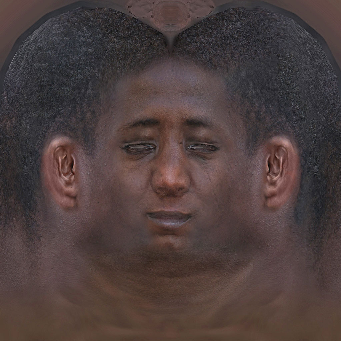

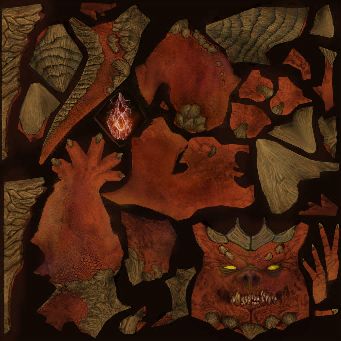

In [37]:
image_show_resize(carregar_tga(REQs["african_head_diffuse.tga"]))
image_show_resize(carregar_tga(REQs["diablo3_pose_diffuse.tga"]))

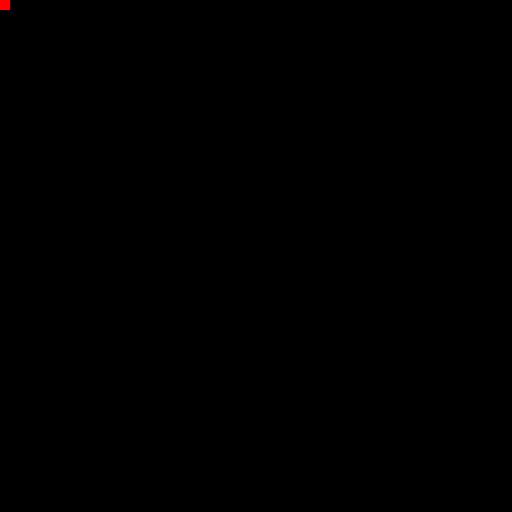

In [29]:
image = np.zeros((512, 512, 3), np.uint8)
for i in range(10):
  for j in range(10):
    image[i][j] = (0, 0, 255)
  
cv2_imshow(image)

In [ ]:
img = np.zeros((WIDTH, HEIGHT, 3), np.uint8)
modelo = carregar_modelo(REQs["african_head.obj"])

for f in modelo:
  v, _, _ = f[-1]
  for u, _, _ in f:
    

      